In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt
from itertools import product
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import contextily as cx

In [2]:
walk_df = pd.read_csv('../data/processed/Bloomington_CBG_Amenity_15_Minute_Walk.csv')
bike_df = pd.read_csv('../data/processed/Bloomington_CBG_Amenity_15_Minute_Bike.csv')

walk_df.drop(['Unnamed: 0', 'TRACTCE', 'rep_x', 'rep_y', 'node_id', 
                'sustenance_distance', 'education_distance', 
                'financial_distance', 'healthcare_distance', 
                'culture_distance', 'public_distance'], axis=1, inplace=True)

bike_df.drop(['Unnamed: 0', 'TRACTCE', 'rep_x', 'rep_y', 'node_id', 
                'sustenance_distance', 'education_distance', 
                'financial_distance', 'healthcare_distance', 
                'culture_distance', 'public_distance'], axis=1, inplace=True)


gdf = walk_df.join(bike_df.set_index('GEOID'), on='GEOID', lsuffix='_walk', rsuffix='_bike')
gdf.drop(['geometry_bike'], axis=1, inplace=True)
gdf.rename(columns={'geometry_walk': 'geometry'}, inplace=True)
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs='epsg:4326')
gdf = gdf.reset_index(drop=True)
gdf
# gdf.sample(5)

,GEOID,geometry,sustenance_time_walk,education_time_walk,financial_time_walk,healthcare_time_walk,culture_time_walk,public_time_walk,sustenance_time_bike,education_time_bike,financial_time_bike,healthcare_time_bike,culture_time_bike,public_time_bike
0,181050005014,"POLYGON ((-86.58634 39.14568, -86.58633 39.145...",92.417442,99.465176,93.323926,91.371023,102.141897,90.070235,21.155766,22.886737,21.450459,21.792718,23.612618,20.578391
1,181050006013,"POLYGON ((-86.56501 39.17101, -86.56500 39.171...",45.953031,51.342370,51.377646,56.508008,54.090269,39.977191,9.826662,11.319353,11.122104,12.511373,11.694734,8.503519
2,181050008012,"POLYGON ((-86.55510 39.18784, -86.55506 39.188...",93.519314,95.097430,99.166458,105.275454,99.766261,86.818641,21.128008,21.755988,22.381254,23.727678,22.686937,19.667039
3,181050008021,"POLYGON ((-86.51460 39.20067, -86.51452 39.200...",74.734115,76.822037,79.946834,91.682065,72.921492,69.663173,17.161355,17.657376,18.383105,20.967647,16.660373,15.988199
4,181050009012,"POLYGON ((-86.50945 39.16823, -86.50915 39.168...",40.566929,45.283772,45.546839,57.804774,35.862206,36.172817,9.419378,10.472501,10.440101,13.316585,8.195561,8.325431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,181050005023,"POLYGON ((-86.60652 39.12788, -86.60530 39.128...",123.308800,130.315522,124.251481,122.209207,133.000858,120.935844,28.050037,29.773816,28.357662,28.679797,30.499697,27.465470
71,181050016001,"POLYGON ((-86.53471 39.17983, -86.53470 39.180...",47.664831,51.363870,52.703441,63.819464,52.514519,39.096058,10.911886,11.968756,12.050391,14.491572,12.078799,9.113222
72,181050016002,"POLYGON ((-86.53856 39.17361, -86.53855 39.173...",37.913985,44.110192,43.284395,53.945817,43.417884,29.233842,8.807074,10.375690,9.951531,12.280626,10.058879,6.927447
73,181050016003,"POLYGON ((-86.52836 39.17864, -86.52833 39.179...",36.655242,41.337548,41.860592,54.358083,38.649740,28.254739,8.474365,9.764003,9.716638,12.522599,8.994542,6.588685


In [35]:
def assign_bivariate_color(df, amenity, modes, palette, boundary=None):
    mode1, mode2 = modes
    if boundary == None:
        x_q1 = df[f"{amenity}_time_{mode1}"].quantile(.25)
        x_q2 = df[f"{amenity}_time_{mode1}"].quantile(.5)
        x_q3 = df[f"{amenity}_time_{mode1}"].quantile(.75)
        x_q4 = df[f"{amenity}_time_{mode1}"].quantile(1.)

        y_q1 = df[f"{amenity}_time_{mode2}"].quantile(.25)
        y_q2 = df[f"{amenity}_time_{mode2}"].quantile(.5)
        y_q3 = df[f"{amenity}_time_{mode2}"].quantile(.75)
        y_q4 = df[f"{amenity}_time_{mode2}"].quantile(1.)

        boundary = [[x_q1, x_q2, x_q3, x_q4], [y_q1, y_q2, y_q3, y_q4]]

    for idx, row in df.iterrows():
        if row[f"{amenity}_time_{mode1}"] < boundary[0][0]:
            x_idx = 0
        elif row[f"{amenity}_time_{mode1}"] < boundary[0][1]:
            x_idx = 1
        elif row[f"{amenity}_time_{mode1}"] < boundary[0][2]:
            x_idx = 2
        else:
            x_idx = 3

        if row[f"{amenity}_time_{mode2}"] < boundary[1][0]:
            y_idx = 0
        elif row[f"{amenity}_time_{mode2}"] < boundary[1][1]:
            y_idx = 1
        elif row[f"{amenity}_time_{mode2}"] < boundary[1][2]:
            y_idx = 2
        else:
            y_idx = 3 
        df.at[idx, 'color'] = palette[x_idx][y_idx]
    
    return boundary

def plot_bivariate_choropleth(gdf, amenity, modes, boundary=None):
    palette = [['#e7e7e7', '#d9bbd3', '#cb8fbf', '#bd64ab'], 
            ['#b8dcdc', '#abb1c9', '#9e86b6', '#925ba3'], 
            ['#89d2d2', '#7da7c0', '#727cae', '#66529b'], 
            ['#5ac7c7', '#4f9db6', '#4573a5', '#3b4993']]
    palette_flat = ['#e7e7e7', '#d9bbd3', '#cb8fbf', '#bd64ab',
     '#b8dcdc', '#abb1c9', '#9e86b6', '#925ba3',
      '#89d2d2', '#7da7c0', '#727cae', '#66529b',
       '#5ac7c7', '#4f9db6', '#4573a5', '#3b4993']
    df = gdf.copy()
    alpha = 1.
    if boundary == None:
        boundary = assign_bivariate_color(df=df, amenity=amenity, modes=modes, palette=palette)
    else:
        assign_bivariate_color(df=df, amenity=amenity, modes=modes, palette=palette, boundary=boundary)
    


    fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
    ax.set_ylim(39.0, 39.3)
    df.plot(color=df['color'], ax=ax, edgecolor='w', lw=0.2) 
    ax.set_title(f"{amenity} travel time", fontsize=15)
    ax.locator_params(axis='x', nbins=4)

    # bivariate legend
    ax = ax.inset_axes([0.7, 0.01, 0.25, 0.25])
    ax.set_aspect('equal', adjustable='box')
    count = 0
    xticks = [0]
    yticks = [0]
    for i,percentile_bound_p1 in enumerate(boundary[0]):
        for j,percentile_bound_p2 in enumerate(boundary[0]):
            percentileboxes = [Rectangle((i,j), 1, 1)]
            pc = PatchCollection(percentileboxes, facecolor=palette_flat[count], alpha=alpha)
            count += 1
            ax.add_collection(pc)
            if i == 0:
                yticks.append(percentile_bound_p2)
        xticks.append(percentile_bound_p1)

            
    _=ax.set_xlim([0,len(boundary[0])])
    _=ax.set_ylim([0,len(boundary[0])])
    _=ax.set_xticks(list(range(len(boundary[0])+1)), xticks)
    _=ax.set_xlabel('walk travel time')
    _=ax.set_yticks(list(range(len(boundary[0])+1)), yticks)
    _=ax.set_ylabel('bike travel time')

    
    plt.savefig(f'../figs/05-bivariate-choropleth-{amenity}.png', 
                format="png", 
                dpi=300)
    plt.show()

    return df

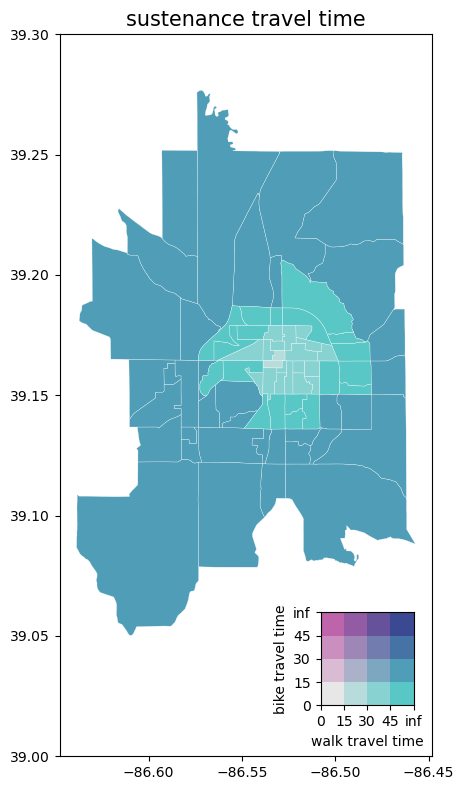

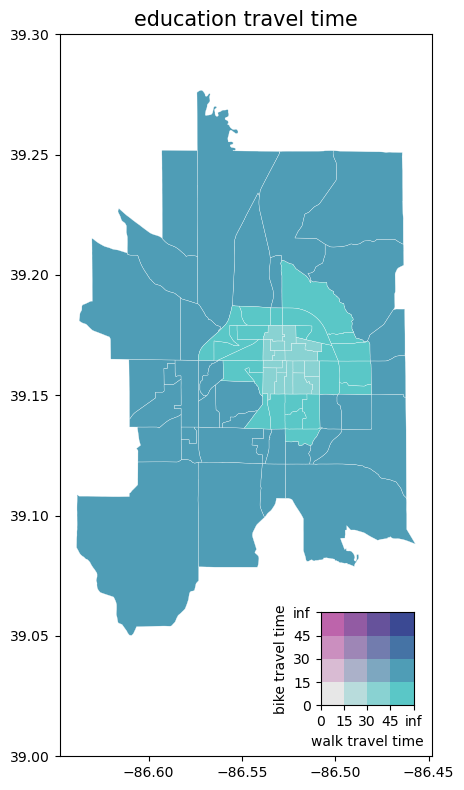

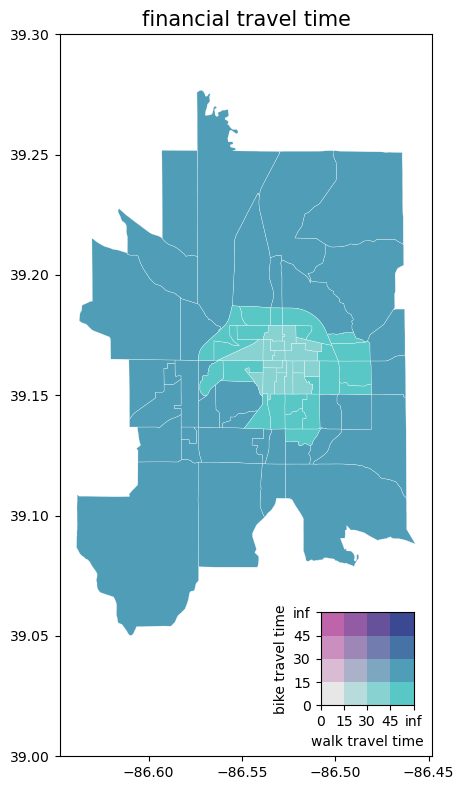

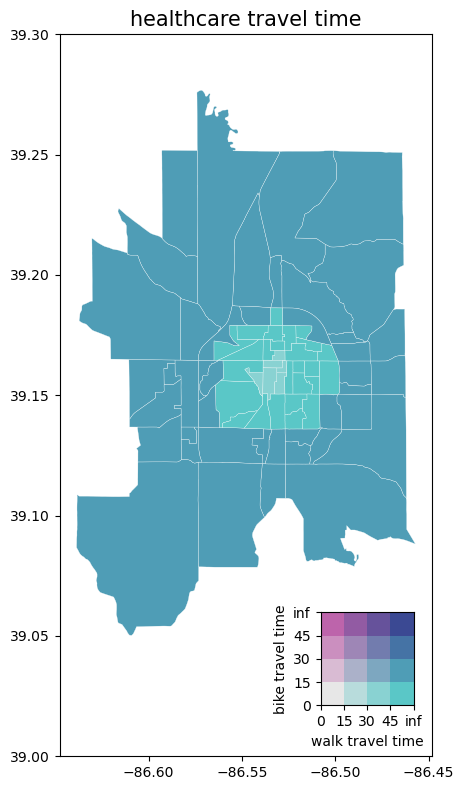

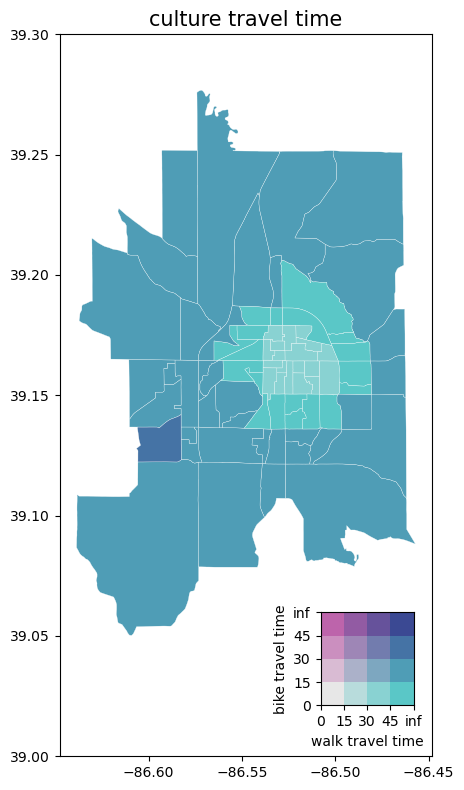

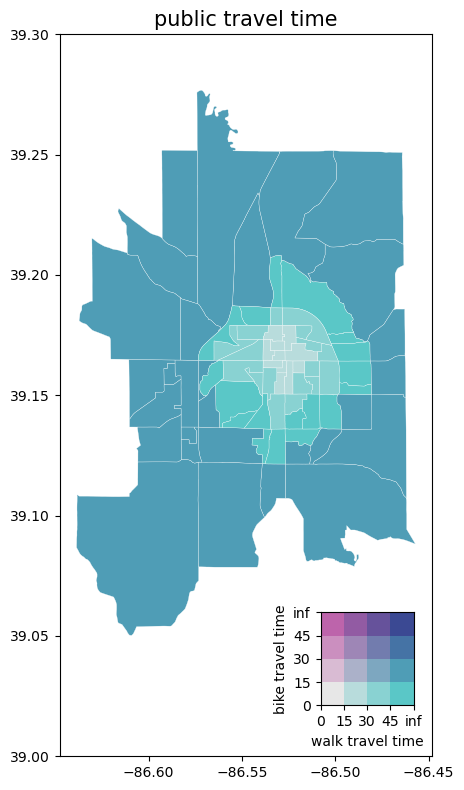

In [36]:
boundary = [[15, 30, 45, np.inf], [15, 30, 45, np.inf]]
amenity_category = ['sustenance', 'education', 'financial', 'healthcare', 'culture', 'public']

for amenity in amenity_category:
    plot_bivariate_choropleth(gdf, amenity=amenity, modes=['walk', 'bike'], boundary=boundary)

In [99]:
df

,GEOID,geometry,sustenance_time_walk,education_time_walk,financial_time_walk,healthcare_time_walk,culture_time_walk,public_time_walk,sustenance_time_bike,education_time_bike,financial_time_bike,healthcare_time_bike,culture_time_bike,public_time_bike,color
0,181050005014,"POLYGON ((-86.58634 39.14568, -86.58633 39.145...",92.417442,99.465176,93.323926,91.371023,102.141897,90.070235,21.155766,22.886737,21.450459,21.792718,23.612618,20.578391,#3b4993
1,181050006013,"POLYGON ((-86.56501 39.17101, -86.56500 39.171...",45.953031,51.342370,51.377646,56.508008,54.090269,39.977191,9.826662,11.319353,11.122104,12.511373,11.694734,8.503519,#925ba3
2,181050008012,"POLYGON ((-86.55510 39.18784, -86.55506 39.188...",93.519314,95.097430,99.166458,105.275454,99.766261,86.818641,21.128008,21.755988,22.381254,23.727678,22.686937,19.667039,#3b4993
3,181050008021,"POLYGON ((-86.51460 39.20067, -86.51452 39.200...",74.734115,76.822037,79.946834,91.682065,72.921492,69.663173,17.161355,17.657376,18.383105,20.967647,16.660373,15.988199,#66529b
4,181050009012,"POLYGON ((-86.50945 39.16823, -86.50915 39.168...",40.566929,45.283772,45.546839,57.804774,35.862206,36.172817,9.419378,10.472501,10.440101,13.316585,8.195561,8.325431,#bd64ab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,181050005023,"POLYGON ((-86.60652 39.12788, -86.60530 39.128...",123.308800,130.315522,124.251481,122.209207,133.000858,120.935844,28.050037,29.773816,28.357662,28.679797,30.499697,27.465470,#3b4993
71,181050016001,"POLYGON ((-86.53471 39.17983, -86.53470 39.180...",47.664831,51.363870,52.703441,63.819464,52.514519,39.096058,10.911886,11.968756,12.050391,14.491572,12.078799,9.113222,#925ba3
72,181050016002,"POLYGON ((-86.53856 39.17361, -86.53855 39.173...",37.913985,44.110192,43.284395,53.945817,43.417884,29.233842,8.807074,10.375690,9.951531,12.280626,10.058879,6.927447,#bd64ab
73,181050016003,"POLYGON ((-86.52836 39.17864, -86.52833 39.179...",36.655242,41.337548,41.860592,54.358083,38.649740,28.254739,8.474365,9.764003,9.716638,12.522599,8.994542,6.588685,#bd64ab


In [ ]:
def plot_bivariate_choropleth_old(gdf, amenity, modes, boundary=None):
    palette = [['#e7e7e7', '#d9bbd3', '#cb8fbf', '#bd64ab'], 
            ['#b8dcdc', '#abb1c9', '#9e86b6', '#925ba3'], 
            ['#89d2d2', '#7da7c0', '#727cae', '#66529b'], 
            ['#5ac7c7', '#4f9db6', '#4573a5', '#3b4993']]
    palette_flat = ['#e7e7e7', '#d9bbd3', '#cb8fbf', '#bd64ab',
     '#b8dcdc', '#abb1c9', '#9e86b6', '#925ba3',
      '#89d2d2', '#7da7c0', '#727cae', '#66529b',
       '#5ac7c7', '#4f9db6', '#4573a5', '#3b4993']
    df = gdf.copy()
    alpha = 1.
    if boundary == None:
        boundary = assign_bivariate_color(df=df, amenity='sustenance', modes=modes, palette=palette)
    else:
        assign_bivariate_color(df=df, amenity='sustenance', modes=modes, palette=palette, boundary=boundary)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_ylim(39.02, 39.3)
    df.plot(color=df['color'], ax=ax, edgecolor='w', lw=0.2) 

    # for legend
    ax2 = fig.add_axes([0.6, 0.15, 0.1, 0.1])
    # Column 1
    ax2.axvspan(xmin=0, xmax=0.25, ymin=0, ymax=0.25, alpha=alpha, color=palette[0][0])
    ax2.axvspan(xmin=0, xmax=0.25, ymin=0.25, ymax=0.5, alpha=alpha, color=palette[0][1])
    ax2.axvspan(xmin=0, xmax=0.25, ymin=0.5, ymax=0.75, alpha=alpha, color=palette[0][2])
    ax2.axvspan(xmin=0, xmax=0.25, ymin=0.75, ymax=1, alpha=alpha, color=palette[0][3])

    # Column 2
    ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0, ymax=0.25, alpha=alpha, color=palette[1][0])
    ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0.25, ymax=0.5, alpha=alpha, color=palette[1][1])
    ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0.5, ymax=0.75, alpha=alpha, color=palette[1][2])
    ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0.75, ymax=1, alpha=alpha, color=palette[1][3])

    # Column 3
    ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0, ymax=0.25, alpha=alpha, color=palette[2][0])
    ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0.25, ymax=0.5, alpha=alpha, color=palette[2][1])
    ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0.5, ymax=0.75, alpha=alpha, color=palette[2][2])
    ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0.75, ymax=1, alpha=alpha, color=palette[2][3])

    # Column 4
    ax2.axvspan(xmin=0.75, xmax=1, ymin=0, ymax=0.25, alpha=alpha, color=palette[3][0])
    ax2.axvspan(xmin=0.75, xmax=1, ymin=0.25, ymax=0.5, alpha=alpha, color=palette[3][1])
    ax2.axvspan(xmin=0.75, xmax=1, ymin=0.5, ymax=0.75, alpha=alpha, color=palette[3][2])
    ax2.axvspan(xmin=0.75, xmax=1, ymin=0.75, ymax=1, alpha=alpha, color=palette[3][3])

    ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
    ax2.axis('off'); # turn off its axis

    ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1, color='k')) # draw arrow for x 
    ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1, color='k')) # draw arrow for y 
    if boundary == None:
        ax2.text(s=f'{modes[0]} time quartile', x=0., y=-0.2) # annotate x axis
        ax2.text(s=f'{modes[1]} time quartile', x=-0.2, y=0.06, rotation=90); # annotate y axis
    else:
        ax2.text(s=f'{modes[0]} time (min)', x=0., y=-0.2) # annotate x axis
        ax2.text(s=f'{modes[1]} time (min)', x=-0.2, y=0.06, rotation=90); # annotate y axis
    fig.set_size_inches(12, 12)
    # plt.tight_layout()

    return df

In [ ]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)